# Sentiment Analysis using Machine Learning
## Project Pipeline

This section provides a basic outline of the steps taken towards building the emotion classification model.

1. **Data Loading and EDA** – Importing and exploring the dataset.
2. **Class Balancing** – Upsampling key emotion classes to handle imbalance.
3. **Data Cleaning** – Text preprocessing including lowercasing, stopword handling, punctuation removal, etc.
4. **Feature Extraction** – TF-IDF vectorization using unigrams and bigrams.
5. **Model Training** – Using SGDClassifier for text classification.
6. **Evaluation** – Accuracy, precision, recall, f1-score, and confusion matrix.
7. **Model Deployment** – Saving models using `joblib` and creating a Gradio GUI for real-time inference.


In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import neattext as nt 
import neattext.functions as nfx

from spellchecker import SpellChecker
from collections import Counter
from wordcloud import WordCloud
import joblib

#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')

## Data Loading & EDA

The dataset used for this project is from Kaggle -> https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text

In [2]:
df = pd.read_csv("emotion_sentimen_dataset.csv")

In [3]:
df.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


### Exploratory Data Analysis
Exploratory Data Analysis (EDA)
The following code performs an initial exploratory analysis of the dataset used to train the emotion classification model. This model is designed to predict basic emotions conveyed through input text.

Key steps include:
-  Dropping Unnecessary columns
-  Capitalizing column and names for clarity and consistency & making it easier to differentiate it from variable with same name
-  Checking for null values (none were found)
-  Checking for duplicates and dropping them
-  Exploring the unique emotion labels present in the dataset
-  Converting the Emotion column from object to categorical type to optimize memory and facilitate easier processing

In [4]:
df = df.drop(columns=["Unnamed: 0"])

In [5]:
df.head()

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


In [7]:
df = df.rename(columns = {"text": "Text" }) # capitalizing to diffrentiate variable names and column names

In [8]:
df.head()

,Text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


In [9]:
df.duplicated().sum()

445733

In [11]:
df = df.drop_duplicates()

In [12]:
df['Emotion'].unique()

array(['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness',
       'fun', 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom'],
      dtype=object)

In [13]:
df['Emotion'] = df['Emotion'].astype('category') 

In [14]:
nulls_per_column = df.isnull().sum()
nulls_per_column

Text       0
Emotion    0
dtype: int64

In [15]:
df.shape

(393822, 2)

In [16]:
# This function is This function is written to plot the distribution of emotion classes using a bar chart.
def visualise(data):
    sns.set(style="whitegrid")
    emotion_counts = data['Emotion'].value_counts().sort_values()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.values, y=emotion_counts.index, palette="viridis")
    plt.title("Emotion Distribution", fontsize=16)
    plt.xlabel("Count", fontsize=12)
    plt.ylabel("Emotion", fontsize=12)
    warnings.filterwarnings("ignore")

### Distribution plot of the emotions
As seen throught the barplot below, the emotion 'neutral' has the most amount of entries, making the data highly imbalanced. 

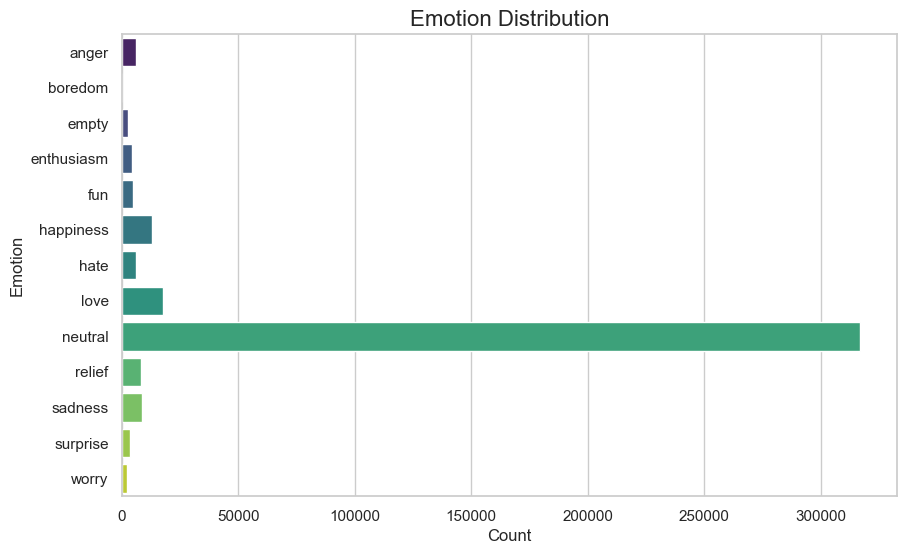

In [18]:
visualise(df)

## Class Balancing

### Binning 
To make the model unibaised, its very important to balance the data across the emotions. To do so I have used the process of binning, where I am grouping closely related sub-emotions into a primary category of emotions. This step helps in reducing confusion caused by label complexity and also improving model generalization. I also removed the neutral class, as these entries often lacked clear emotional cues and could introduce noise into the model. For this project, focusing on distinctly labeled emotional expressions ensured cleaner training data and more accurate predictions

In [19]:
binning = {
    'hate': 'anger',
    'neutral': None,
    'anger': 'anger',
    'love': 'love',
    'worry': 'sadness',
    'relief': 'joy',
    'happiness': 'joy',
    'fun': 'joy',
    'empty': 'sadness',
    'enthusiasm': 'joy',
    'sadness': 'sadness',
    'surprise': 'joy',
    'boredom': 'sadness'
    
}
df['Emotion'] = df['Emotion'].replace(binning)
df = df.dropna(subset=['Emotion']).reset_index(drop=True)

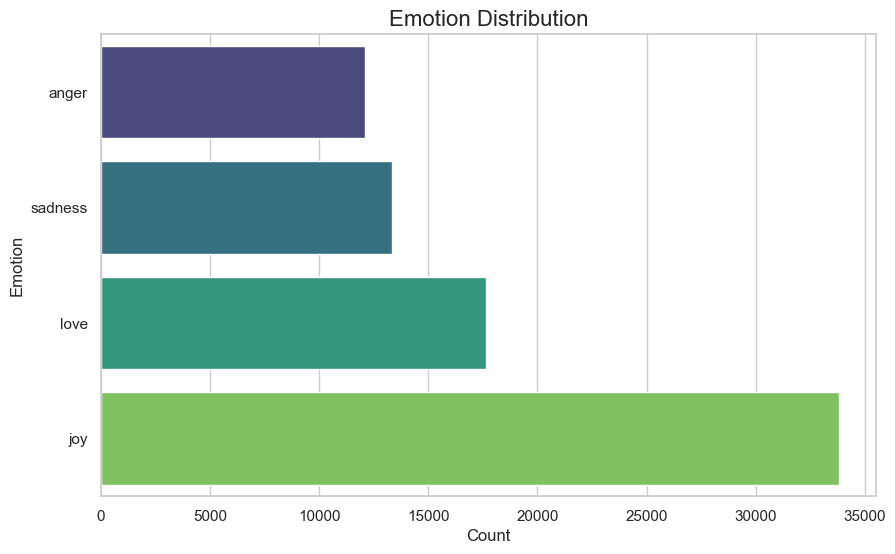

In [20]:
visualise(df)

### Sampling 
Even after binning, the class distribution remained imbalanced, with joy having significantly higher counts (around 35,000), while anger , love and sadness were both below 15,000. Training the model on such skewed data could lead to bias toward the majority classes. To address this, I applied random undersampling to the major classes, bringing all four categories to approximately 15,000 samples each for balanced training.

In [21]:
df_love = df[df['Emotion'] == "love"].sample(n= 15000, random_state = 42)
df_joy = df[df['Emotion'] == "joy"].sample(n= 15000, random_state = 42)
df_others = df[~df['Emotion'].isin([ 'joy', 'love'])]

In [22]:
df_balanced = pd.concat([df_love, df_joy, df_others])

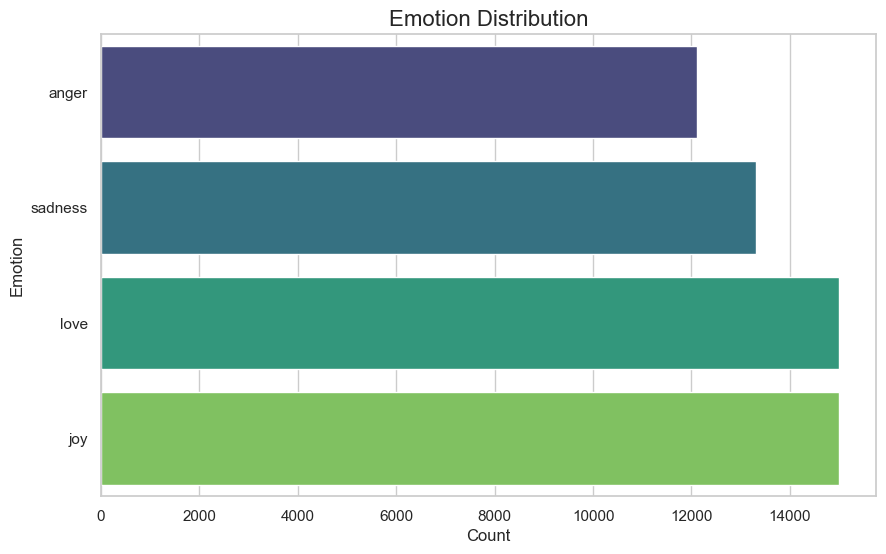

In [23]:
visualise(df_balanced)

## Data Cleaning

The function *text_preprocess* below shows The data cleaning process which includes turning the text variable into lower case, 
Removing stop words and user handles,
Handling punctuation, Tokenization and lemmatization.
This step is essential for model development, as it will help reduce noise, standardize the text, and ensure that only the most meaningful parts of the input are retained for emotion classification.

In [24]:
lemmatizer = WordNetLemmatizer()

In [25]:
def text_preprocess(text):
    text = text.lower()
    
    text = nfx.remove_userhandles(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_punctuations(text)
    
    words = word_tokenize(text)
    
    #words = correct_it(words)
    
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word is not None]
    
    text_processed = " ".join(lemmatized_words)
    
    return text_processed

In [26]:
df_balanced['Text_clean'] = df_balanced['Text'].apply(text_preprocess)

In [27]:
df_balanced

,Text,Emotion,Text_clean
22013,im feeling all romantic and soppy and grateful...,love,im feeling romantic soppy grateful lovely husband
18790,i just want to feel like im really loved for b...,love,want feel like im loved person half person time
59201,im sure even those who didnt have the pleasure...,love,im sure didnt pleasure close sl feel loss felt...
21761,i feel the way i imagine someone feels when th...,love,feel way imagine feel beloved pet turn bite be...
685,i prayed for love for the people that i was fe...,love,prayed love people feeling bitter find best
...,...,...,...
76880,i actually feel like the smart one in class ra...,anger,actually feel like smart class average student
76881,i think i hate my job because i feel i m being...,anger,think hate job feel valued utilized
76884,i have very little pity and or detest feeling ...,anger,little pity detest feeling pity going pain unf...
76885,i was feeling very weepy and sad and asked my ...,sadness,feeling weepy sad asked unbelievably kind pati...


### Word frequency for each emotion
The code below plots the frequency of words observed for each emotion.
This helps in understanding which words are most commonly associated with specific emotions, providing insight into the linguistic patterns tied to each emotional category.

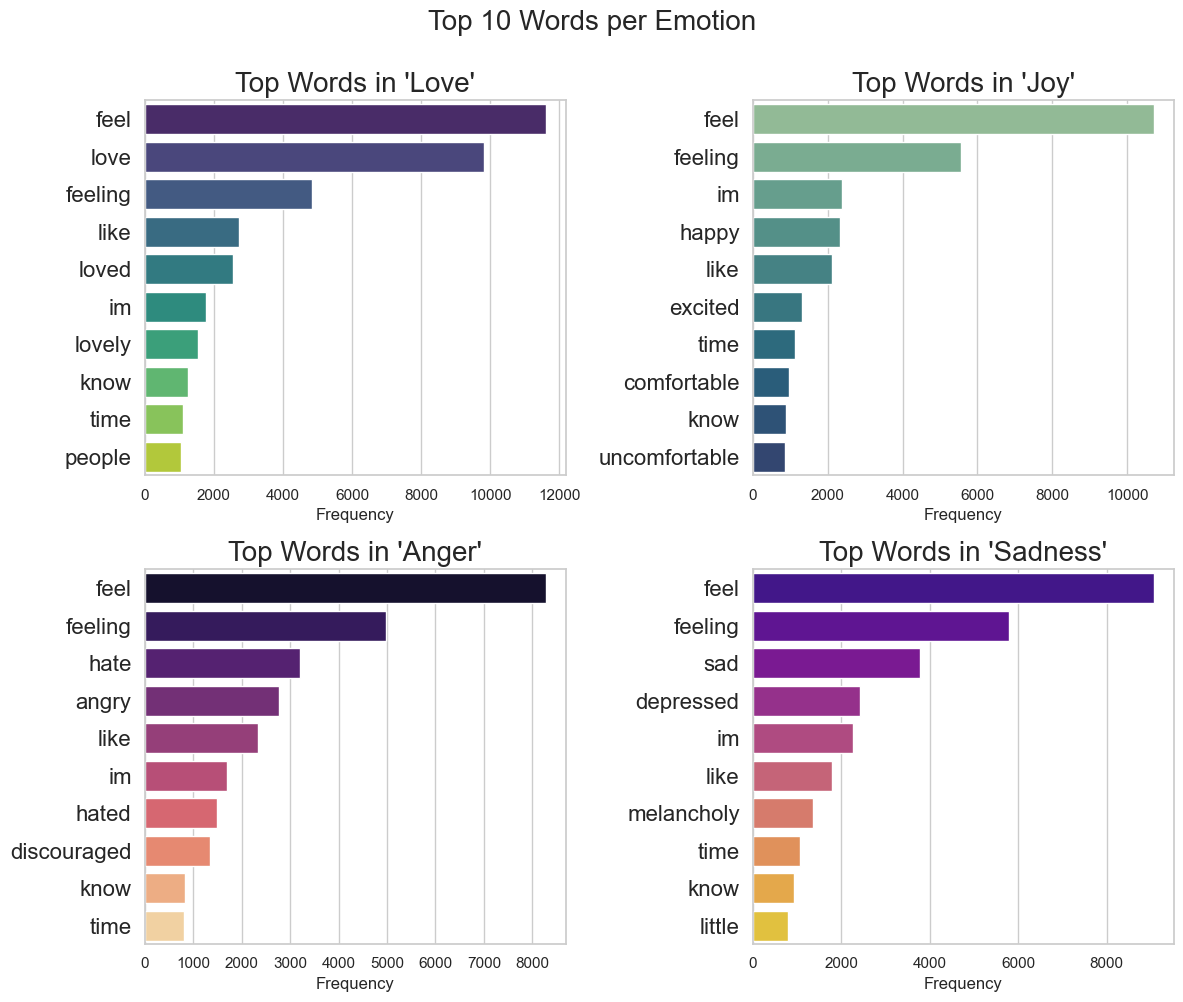

In [28]:
# Array of different colormap themes
palettes = ['viridis', 'crest', 'magma', 'plasma', 'rocket', 'flare', 'coolwarm', 'cubehelix', 'Set2', 'pastel'] 

emotions = df_balanced['Emotion'].unique()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
axes = axes.flatten()

for i, emotion in enumerate(emotions):
    ax = axes[i]
    emotion_words = ' '.join(df_balanced[df_balanced['Emotion'] == emotion]['Text_clean']).split()
    top_words = Counter(emotion_words).most_common(10)
    words, counts = zip(*top_words)

    sns.barplot(x=counts, y=words, palette=palettes[i % len(palettes)], ax=ax) # To use a different colormap per emotion
    ax.set_title(f"Top Words in '{emotion.capitalize()}'", fontsize=20)
    ax.tick_params(axis='y', labelsize=16) 
    ax.set_xlabel("Frequency")
    ax.set_ylabel("")

plt.suptitle("Top 10 Words per Emotion", fontsize=20, y=1)
plt.tight_layout()
plt.show()

As the above plot shows, words like feel and feeling are among the most frequent across all emotions. These words, although emotional in nature, are common to multiple classes and do not contribute uniquely to any specific emotion. Since the machine learning model doesn't retain the sequence or context in the same way a deep learning models do, such common words can introduce noise and confusion. Therefore, removing them will help the model focus on more distinctive and unique features to each emotion and that will also help in improving classification accuracy.

In [29]:
custom_stopwords = ['feel', 'feeling']
def remove(text):
    cleaned = " ".join([word for word in text.split()if word not in custom_stopwords])
    return cleaned

In [30]:
df_balanced['Text_clean'] = df_balanced['Text_clean'].apply(remove)

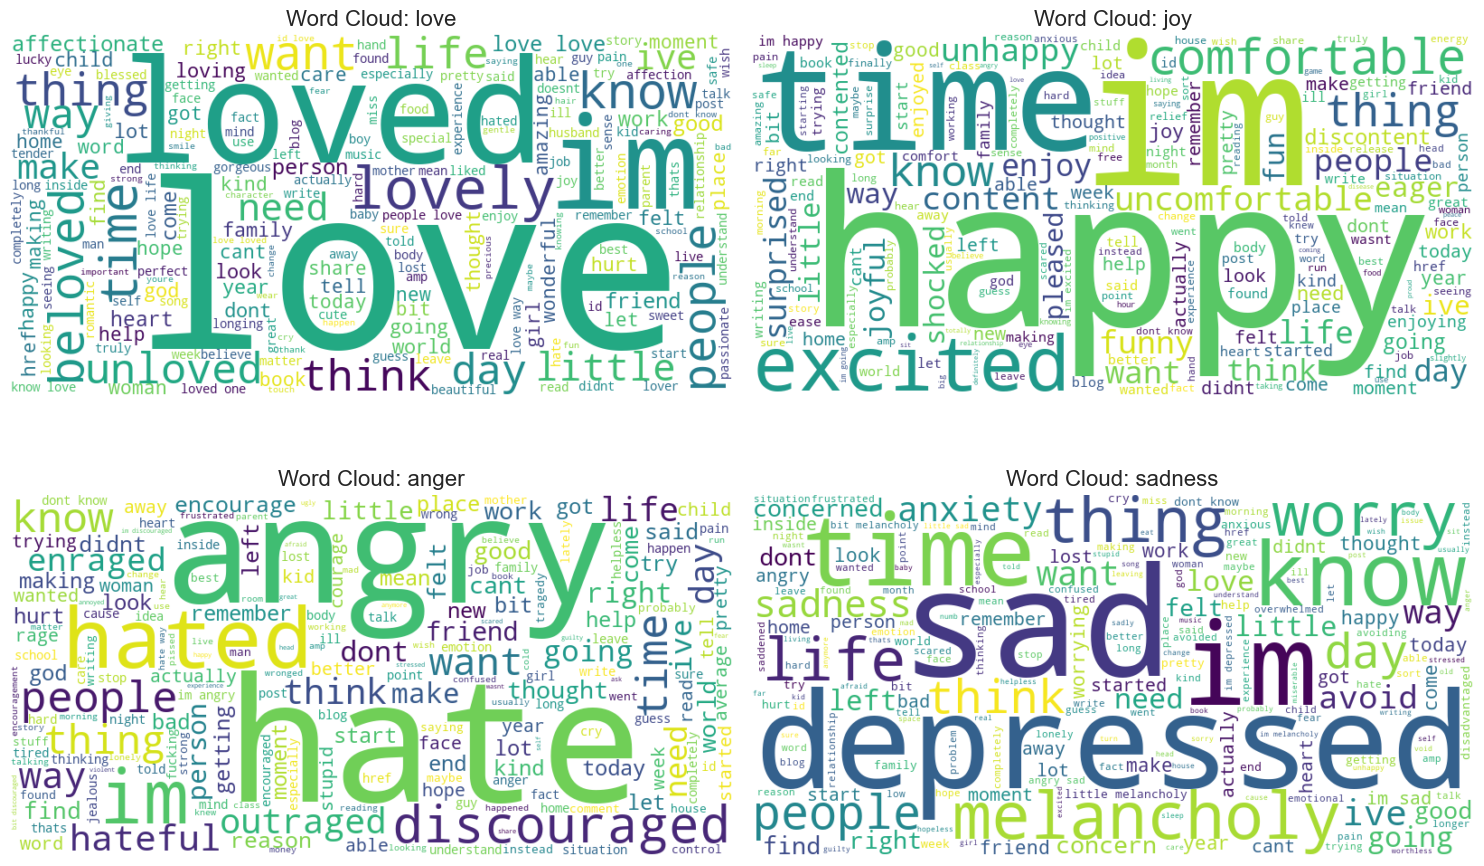

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True) 
fig.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten()  

for i, emotion in enumerate(emotions):
    text_data = " ".join(df_balanced[df_balanced['Emotion'] == emotion]['Text_clean'])
  
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_data)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"Word Cloud: {emotion}", fontsize=16)
    axes[i].axis('off')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

As the word clouds for each emotion show, the emotions are dominated by words that describe them most distinctly. This helps the vectorizer assign more meaningful weights to those distinguishing terms during feature extraction, ultimately improving the model’s ability to classify emotions accurately. 

## Feature Extraction
The section below demonstrates feature extraction, which is converting cleaned text into numerical values that a machine learning model can understand.
Before applying this, the data is split into training and testing sets. This is done to prevent the model (or the vectorizer) from "seeing"/ getting used to the test data during training, helping ensure a fair and unbiased evaluation.

A *TfidfVectorizer* is then initialized with:

- max_features=30000 to limit to the top 30,000 most important words/phrases.

-  ngram_range=(1, 2) to include both unigrams (single words like "happy") and bigrams (two-word phrases like "very happy", "not sad") to capture more contextual meaning.

The LabelEncoder is also initialized to convert the categorical emotion labels into numerical form. But during training
The vectorizer and encoder are both fitted and transformed on the training set.
On the test set, its only transform (not fit) to avoid data leakage, making sure the test data doesn't influence what the model learns.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced["Text_clean"], df_balanced["Emotion"], 
                                                    test_size=0.2, random_state=42, stratify = df_balanced["Emotion"])

In [54]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [55]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [56]:
encoder = LabelEncoder()

In [57]:
y_train = encoder.fit_transform(y_train)
y_test  = encoder.transform(y_test)

In [58]:
list(encoder.classes_)

['anger', 'joy', 'love', 'sadness']

List of encoders 
-  [0] - anger
-  [1] - joy 
-  [2] - love
-  [3] - sadness

## Model Training
For training the final classifier, I chose SGDClassifier (Stochastic Gradient Descent), which is particularly well-suited for large-scale, sparse datasets like text data after vectorization.The model was initialized with the following parameters:
- loss='log_loss': This specified that the model should use logistic regression. As Logistic regression is a widely used method for multi-class classification, and using 'log_loss' enables probability-based predictions.

- max_iter=1000: This number controls counts of iterations over the training data. I chose 1000 as a balanced value, high enough to ensure convergence, but not too high to cause unnecessary computation time.

Overall, I selected SGDClassifier after comparing it with other models (like Random Forest, XGBoost and SVM), and found that it performed best on unseen sentences, generalizing well while maintaining simplicity and speed.

In [59]:
sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)
sgd_model.fit(X_train, y_train)
y_pred_sgd = sgd_model.predict(X_test)

In [60]:
print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2423
           1       0.88      0.97      0.92      3000
           2       0.97      0.98      0.98      3000
           3       0.97      0.88      0.93      2663

    accuracy                           0.94     11086
   macro avg       0.94      0.94      0.94     11086
weighted avg       0.94      0.94      0.94     11086



## Evaluation

Looking at the metrics above for my final SGDClassifier, the results were quite satisfying:

- Overall accuracy stands at 94%, which shows that the model is performing really well on the validation set.

- The precision, recall, and F1-score across all four emotion classes — anger (0), joy (1), love (2), sadness (3) are fairly balanced, all hovering around 92–98%.

What I observed was:

- Class 1 (joy) shows the highest recall (0.97), which is great because it means most joy-related texts are being correctly identified.

- Class 3 (sadness) has a slightly lower recall at 0.88, meaning a few sad instances are being confused as something else — possibly joy or love.

- The F1-scores are consistently strong across the board, which reflects a good balance between precision and recall — making the model robust, not just biased towards high frequency classes.


### Confusion Matrix Evaluation
The confusion matrix below provides a deeper look into how the model is classifying each emotion, The diagonal cells are the correct predictions and as as it can be seen the values of diagonal cells are quite high, especially for class 2 (love) and class 1 (joy).
Most misclassifications are for:
- Class 0 (anger) are predicted as class 1 (joy) — likely because of overlapping expressions like “I’m not happy” being misread into "happy" due to negation issues.
- Class 3 (sadness) seems to have more confusion, especially being mistaken as joy or love, possibly due to context-heavy emotional cues.

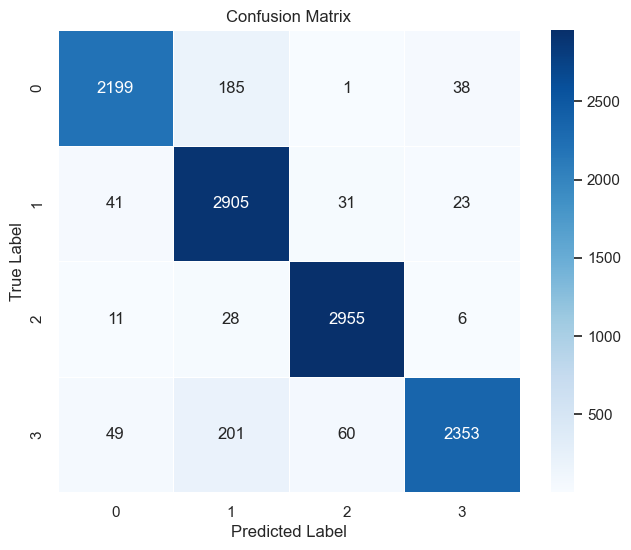

In [64]:
cm = confusion_matrix(y_test, y_pred_sgd)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, square=True,xticklabels=range(4), yticklabels=range(4))
plt.title(f"Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Deployment
*Joblib* to save and load the trained model, vectorizer, and label encoder efficiently. It helped in reusing them later without retraining, making deployment faster and smoother.

In [62]:
joblib.dump(sgd_model, "emotion_sgd_model.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
joblib.dump(encoder, "label_encoder.joblib")

['label_encoder.joblib']

# Conclusion
This project was built to demonstrate a simple yet effective way to perform sentiment analysis using traditional machine learning models. By carefully preparing the data, including cleaning, balancing, and feature extraction, and applying classification techniques like SGDClassifier, the model was able to accurately predict emotions from text inputs. The approach highlights how, with proper preprocessing and thoughtful model selection, even classical ML methods can deliver strong performance in emotion detection tasks.

## Limitations 
-  The dataset used had many emotionally rich sentences incorrectly annotated as neutral, which were later dropped, but this still suggests a lack of high-quality labeling in the source data.

- Handling of negations (e.g., "not happy") posed challenges, as traditional vectorizers like CountVectorizer or TF-IDF do not capture context or sequence well, leading to occasional misclassifications.

- The dataset was highly imbalanced, with emotions like joy and love dominating, while anger and sadness were significantly underrepresented. Although sampling was used to balance the classes, this might have led to loss of nuance in major classes and potential overfitting on minority ones.


## Future Improvements
- The current project bins multiple nuanced emotions into four core categories. A more robust dataset with accurately annotated labels could allow detection of a richer set of emotions like disgust, surprise, relief, or confusion.

- Implement real-time user feedback to allow continuous learning and model improvement.

- To Explore the using of TF-IDF or word embeddings to enrich feature quality.

- Improve negation handling by using custom rules or sentiment-aware tokenization techniques.

